# Learn how to play with ER/NR band

Tunnell, April 2016

This tutorial describes how to draw the ER and NR bands to determine seperation.

The following line just runs our standard code for every analysis.  You can change 'run' to 'load' to see what is in there.

In [1]:
%matplotlib inline
%run boiler_plate.py

# Import the XENON100 configuration from pax
from pax.configuration import load_configuration
pax_config = load_configuration('XENON100')

# Load hax - helpers for analysis
import hax  # rootpy raises a warning, but ignore
hax.init(main_data_paths=['/project/lgrandi/xenon100/archive/root/merged/xenon100/run_14_pax4.1.2',
                          '/project/lgrandi/xenon100/archive/root/merged/xenon100/run_10_pax4.1.2'])

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


## Tritium datasets

Here we choose the tritiated methane datasets:

In [2]:
datasets = ['xe100_151125_1955', 'xe100_151124_1531',
            'xe100_151124_1629', 'xe100_151124_1741',
            'xe100_151124_2006', 'xe100_151124_2234',
            'xe100_151125_0104', 'xe100_151125_0337',
            'xe100_151125_0613', 'xe100_151125_0853',
            'xe100_151125_1133', 'xe100_151125_1417',
            'xe100_151125_1704', 'xe100_151125_1955',
            'xe100_151125_2249', 'xe100_151126_0147',
            'xe100_151126_0449', 'xe100_151126_0754',
            'xe100_151126_1103', 'xe100_151126_1416',
            'xe100_151126_1526', 'xe100_151126_1846',
            'xe100_151126_2208', 'xe100_151127_0136',
            'xe100_151127_0507', 'xe100_151127_0844' ]

datasets = [x + '_pax4.1.2' for x in datasets]

## Load data

Here we genereate the minitrees (formerly: skim files) for each dataset.  After running this command, 'df' will contain all the data and there should also be ntuple ROOT files that appear in your current directory.

In [3]:
df = hax.minitrees.load(datasets)

Found minitree at ./xe100_151125_1955_pax4.1.2_Basics.root
Found minitree at ./xe100_151124_1531_pax4.1.2_Basics.root
Found minitree at ./xe100_151124_1629_pax4.1.2_Basics.root
Found minitree at ./xe100_151124_1741_pax4.1.2_Basics.root
Found minitree at ./xe100_151124_2006_pax4.1.2_Basics.root
Found minitree at ./xe100_151124_2234_pax4.1.2_Basics.root
Found minitree at ./xe100_151125_0104_pax4.1.2_Basics.root
Found minitree at ./xe100_151125_0337_pax4.1.2_Basics.root
Found minitree at ./xe100_151125_0613_pax4.1.2_Basics.root
Found minitree at ./xe100_151125_0853_pax4.1.2_Basics.root
Found minitree at ./xe100_151125_1133_pax4.1.2_Basics.root
Found minitree at ./xe100_151125_1417_pax4.1.2_Basics.root
Found minitree at ./xe100_151125_1704_pax4.1.2_Basics.root
Found minitree at ./xe100_151125_1955_pax4.1.2_Basics.root
Found minitree at ./xe100_151125_2249_pax4.1.2_Basics.root
Found minitree at ./xe100_151126_0147_pax4.1.2_Basics.root
Found minitree at ./xe100_151126_0449_pax4.1.2_Basics.ro

Take at the first 5 events:

In [4]:
df.head()

,index,cs1,cs2,dataset_number,drift_time,event_number,event_time,largest_coincidence,largest_other_s1,largest_other_s2,largest_unknown,largest_veto,s1,s1_area_fraction_top,s2,s2_area_fraction_top,x,y,z
0,0,26.574498,8207.709859,1.511252e+09,111467.828125,0,-363593728,0.0,0.00000,25.146364,0.0,0.0,29.917625,0.181913,6406.849609,0.549000,-1.178571,8.498120,19.283934
1,1,26.717555,8535.272819,1.511252e+09,39061.460938,1,-226821888,0.0,6.62885,41.985134,0.0,0.0,20.694386,0.227523,7825.628906,0.530312,-3.783835,6.513158,6.757633
2,2,7.477378,1534.486105,1.511252e+09,16885.148438,2,-224619776,0.0,0.00000,0.000000,0.0,0.0,5.460357,0.779893,1477.975098,0.526108,-0.310150,-3.039474,2.921131
3,3,15.932814,7100.579123,1.511252e+09,42699.093750,3,-200657920,0.0,0.00000,18.607754,0.0,0.0,12.348376,0.137763,6457.804688,0.564483,10.607142,0.062030,7.386943
4,4,NaN,NaN,1.511252e+09,NaN,4,-140000768,0.0,0.00000,1005.057129,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This is an old version of pax that uses positive $z$.  Therefore, we need to fix this:

In [5]:
df['z'] = -1 * df['z']

## Cuts

The following functions applies cuts to the DataFrame 'df'.

In [6]:
def do_cut(df, cut, name=''):
    """Does a cut (specified as boolean array or Series) on df, modifying it in place.
    Additionally, prints out passthrough info
    """
    n_before = len(df)
    df = df[cut]
    print("%s cut: %d events removed (%0.2f%% passthrough)" % (
            name, n_before - len(df), len(df)/n_before * 100))
    return df

And grab some useful parameters for definig cuts:

In [7]:
tpc_length = pax_config['DEFAULT']['tpc_length']
tpc_radius = pax_config['DEFAULT']['tpc_radius']

Require one interaction (i.e., one S1 and S2 pair)

In [8]:
df = do_cut(df, df['cs1'] > 0, 'At least an interaction')

At least an interaction cut: 704074 events removed (69.06% passthrough)


Let's apply a light fiducial volume cut:

In [9]:
df = do_cut(df, (-0.05 * tpc_length > df['z']) & (df['z'] > - 0.95 * tpc_length), 'z')
df = do_cut(df, (df['x']**2 + df['y']**2)**0.5 < tpc_radius * 0.95, 'radial')

z cut: 218087 events removed (86.12% passthrough)
radial cut: 51889 events removed (96.17% passthrough)


A double scatter cut:

In [10]:
df = do_cut(df, df['largest_other_s2'] < 100, 'Double scatter (absolute)')
df = do_cut(df, df['largest_other_s2'] < 0.5 * df['cs2'], 'Double scatter (relative)')

Double scatter (absolute) cut: 77175 events removed (94.07% passthrough)
Double scatter (relative) cut: 398 events removed (99.97% passthrough)


## Energy spectra

What energy spectrum remains?

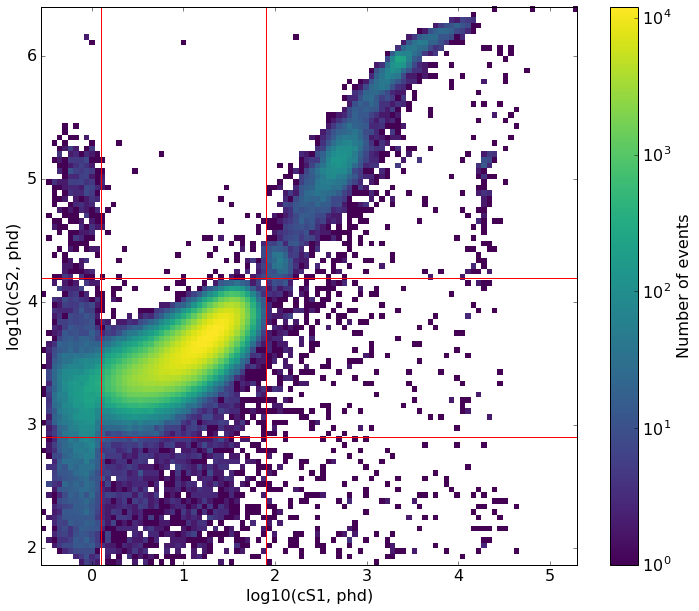

In [11]:
# Make an S1 vs S2 histogram
plt.hist2d(np.log10(df['cs1']), np.log10(df['cs2']),
           bins=100, 
           norm=matplotlib.colors.LogNorm()   # Logarithmic color scale
)
plt.colorbar(label='Number of events')

plt.xlabel('log10(cS1, phd)')
plt.ylabel('log10(cS2, phd)')

# By eye
plt.axvline(0.1, color='red')
plt.axvline(1.9, color='red')
plt.axhline(2.9, color='red')
plt.axhline(4.2, color='red')

plt.show()

Select what looks like the band

In [12]:
df = do_cut(df,    (np.log10(df['cs1']) > 0.1) & 
                   (np.log10(df['cs1']) < 1.9) & 
                   (np.log10(df['cs2']) > 2.9) & 
                   (np.log10(df['cs2']) < 4.2), name='Energy range')

Energy range cut: 31749 events removed (97.41% passthrough)


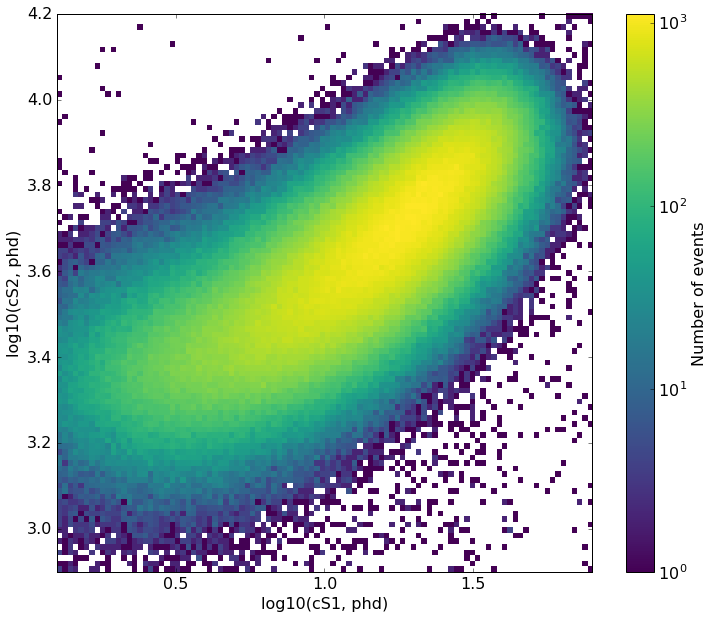

In [13]:
# Make an S1 vs S2 histogram
plt.hist2d(np.log10(df['cs1']), np.log10(df['cs2']),
           bins=100, 
           norm=matplotlib.colors.LogNorm()   # Logarithmic color scale
)
plt.colorbar(label='Number of events')

plt.xlabel('log10(cS1, phd)')
plt.ylabel('log10(cS2, phd)')

plt.show()

We can look at it more in the 'band' way:

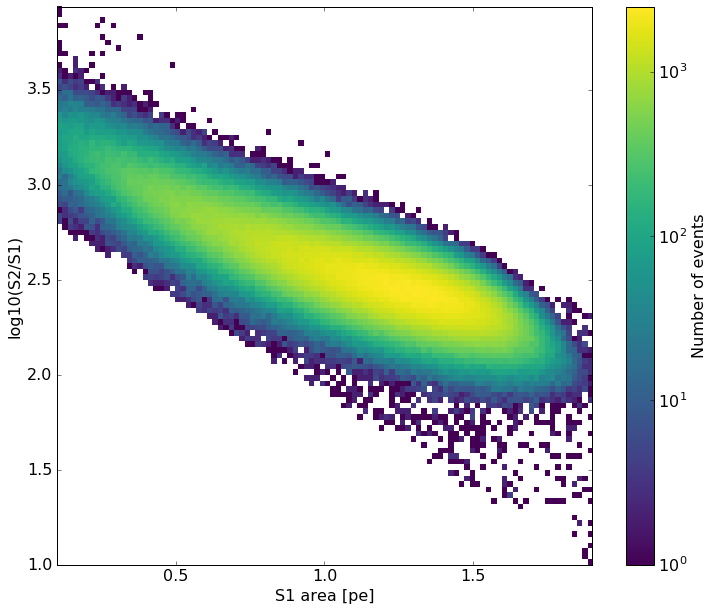

In [14]:
# Make an S1 vs S2 histogram
plt.hist2d(np.log10(df['cs1']), np.log10(df['cs2']/df['cs1']),
           bins=100, 
           norm=matplotlib.colors.LogNorm()   # Logarithmic color scale
)
plt.colorbar(label='Number of events')

plt.xlabel('S1 area [pe]')
plt.ylabel('log10(S2/S1)')

plt.show()